In [118]:
s_ticker = "C"

In [112]:
# all my ticker data is in data folder under <s_ticker>_stock_data.csv naming convention
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

def get_data(ticker):
    data_path = os.path.join("data", f"{ticker}_stock_data.csv")
    if not os.path.exists(data_path):
        print(f"Data file for {ticker} not found.")
        sys.exit(1)
    return pd.read_csv(data_path, index_col=0)

In [119]:
df = get_data(s_ticker)
print(df.head(5))


            Close   High    Low   Open    Volume
2025-06-24  81.14  81.45  79.88  80.00  18393000
2025-06-23  79.36  79.45  77.51  78.37  12007200
2025-06-20  78.45  79.27  78.33  78.88  17336500
2025-06-18  78.35  78.97  77.26  77.40  14866100
2025-06-17  77.36  77.99  77.11  77.50   8078600


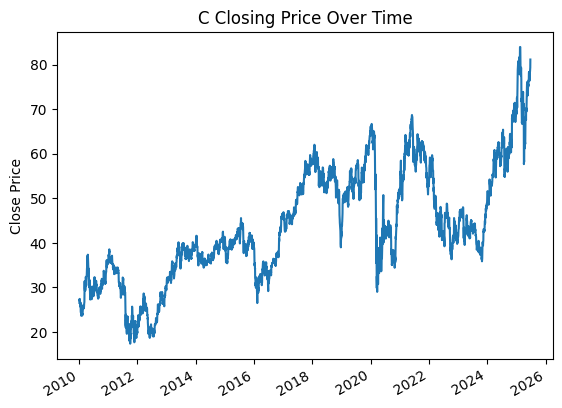

In [120]:
# plot the close price with dates on x-axis

df.index = pd.to_datetime(df.index)
df['Close'].plot()
plt.title(f"{s_ticker} Closing Price Over Time")
plt.ylabel("Close Price")
plt.show()


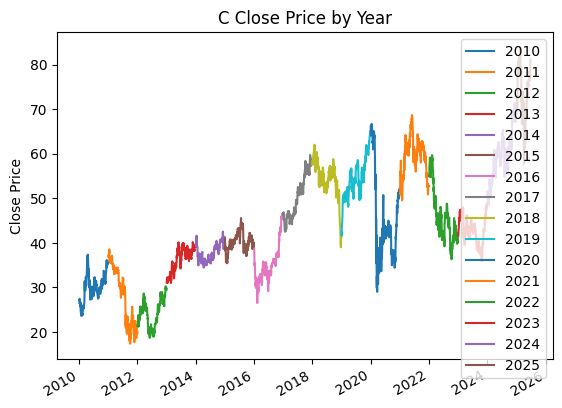

In [89]:
# show close prices for each year. x-axis should be months and y-axis should be close price
df['Year'] = df.index.year
df['Month'] = df.index.month
df.groupby('Year')['Close'].plot(legend=True)
plt.title(f"{s_ticker} Close Price by Year")
plt.ylabel("Close Price")
plt.show()


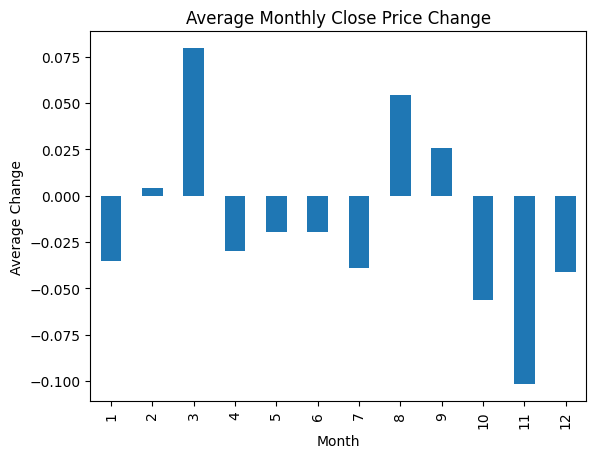

In [90]:
# what is average rate increase for each month
df['Close_diff'] = df['Close'].diff()
df.groupby('Month')['Close_diff'].mean().plot(kind='bar')
plt.title("Average Monthly Close Price Change")
plt.ylabel("Average Change")
plt.show()

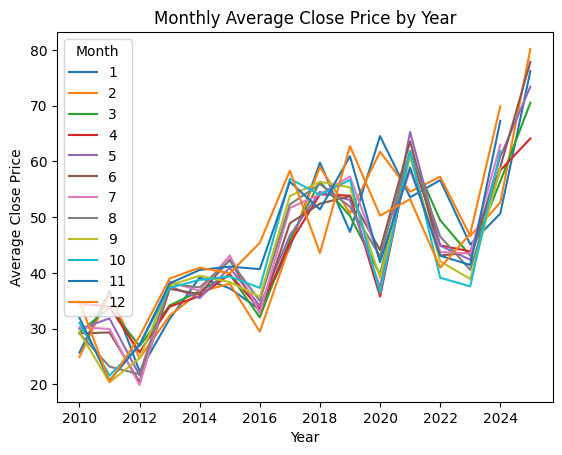

In [91]:
# Show all close prices for each year for each month color coded
df.groupby(['Year','Month'])['Close'].mean().unstack().plot()
plt.title("Monthly Average Close Price by Year")
plt.ylabel("Average Close Price")
plt.show()


In [92]:
%pip install plotly
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [93]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt


import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL, MSTL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

In [94]:
print(df['Close'])

2025-06-24    81.1400
2025-06-23    79.3600
2025-06-20    78.4500
2025-06-18    78.3500
2025-06-17    77.3600
               ...   
2010-01-11    27.2735
2010-01-08    26.9730
2010-01-07    27.4238
2010-01-06    27.3486
2010-01-05    26.5222
Name: Close, Length: 3891, dtype: float64


In [130]:
# Set start and end dates from the file's date range
import yfinance as yf
start = str(df.index.min().date())
end = str(df.index.max().date())
train_start = start
train_end = '2023-12-31'
test_start = '2019-01-01'
test_end = end
period = 12 # for STL decomposition

In [128]:
# create train and test dataframes
train_df = df[(df.index >= train_start) & (df.index <= train_end)]
test_df = df[(df.index >= test_start) & (df.index <= test_end)]


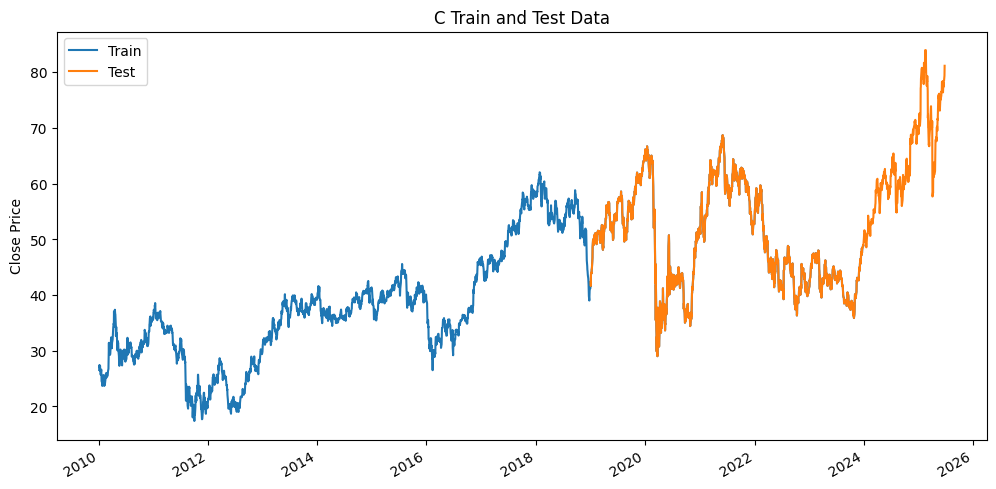

In [129]:
# plot the train and test dataframes
train_df['Close'].plot(label='Train', figsize=(12, 6))
test_df['Close'].plot(label='Test')
plt.title(f"{s_ticker} Train and Test Data")
plt.ylabel("Close Price")
plt.legend()
plt.show()

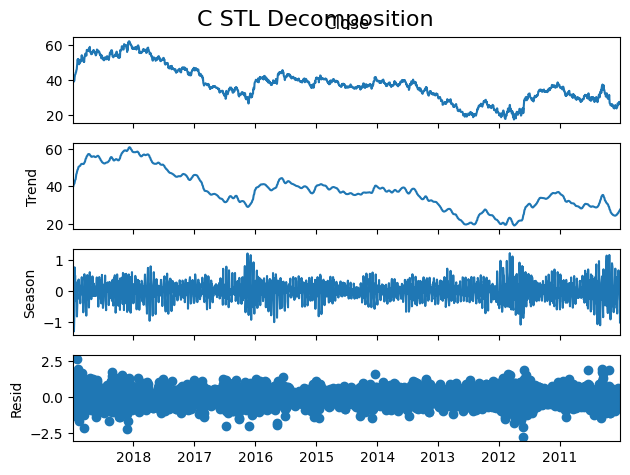

In [98]:
# lets do stl decomposition on the train data
stl = STL(train_df['Close'], period=period)
stl_result = stl.fit()

# plot the STL decomposition
stl_result.plot()
plt.suptitle(f"{s_ticker} STL Decomposition", fontsize=16)
plt.show()



<Figure size 1200x800 with 0 Axes>

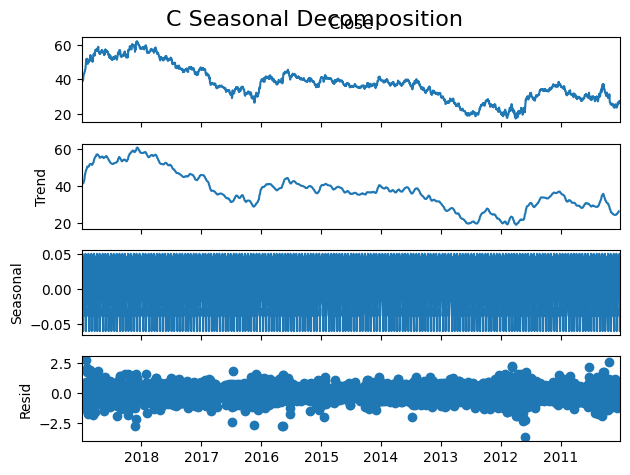

In [99]:
# lets do seasonal decomposition using statsmodels
results = seasonal_decompose(train_df['Close'], model='additive', period=period)


# plot the seasonal decomposition
plt.figure(figsize=(12, 8))
results.plot()
plt.suptitle(f"{s_ticker} Seasonal Decomposition", fontsize=16)
plt.show()

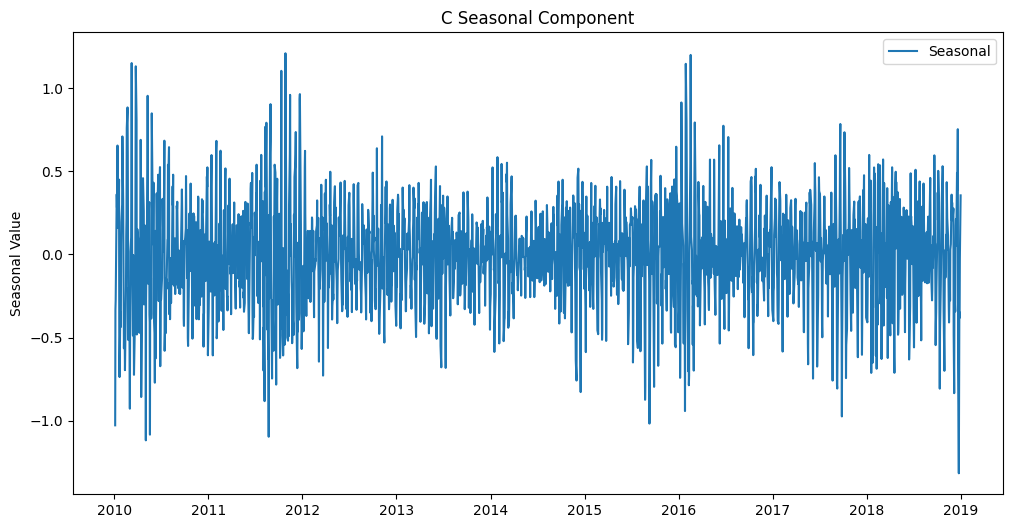

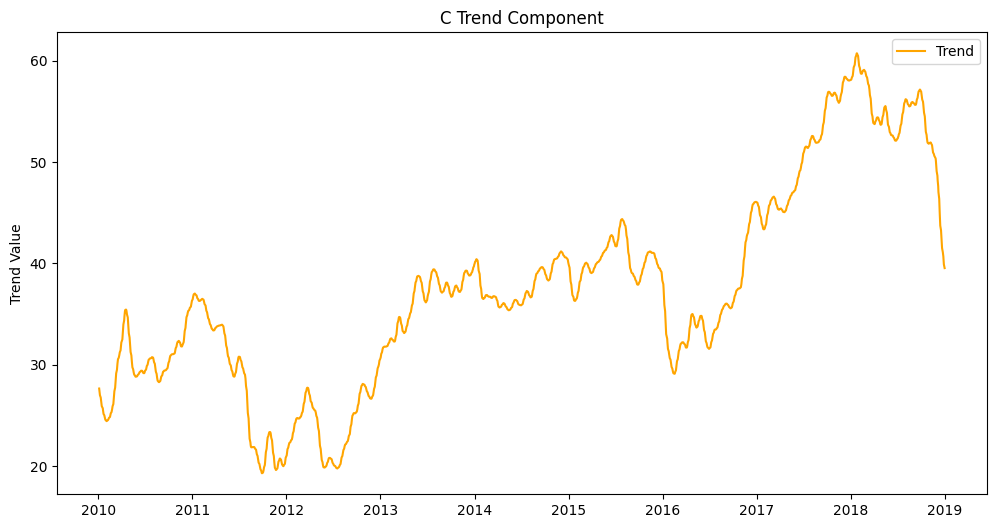

In [100]:
# seasonal is too noisy, lets use STL decomposition
season_and_trend = stl_result.seasonal + stl_result.trend

# lets plot the seasonal and trend components in two separate plots


plt.figure(figsize=(12, 6))
plt.plot(stl_result.seasonal, label='Seasonal')
plt.title(f"{s_ticker} Seasonal Component")
plt.ylabel("Seasonal Value")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(stl_result.trend, label='Trend', color='orange')
plt.title(f"{s_ticker} Trend Component")
plt.ylabel("Trend Value")
plt.legend()
plt.show()

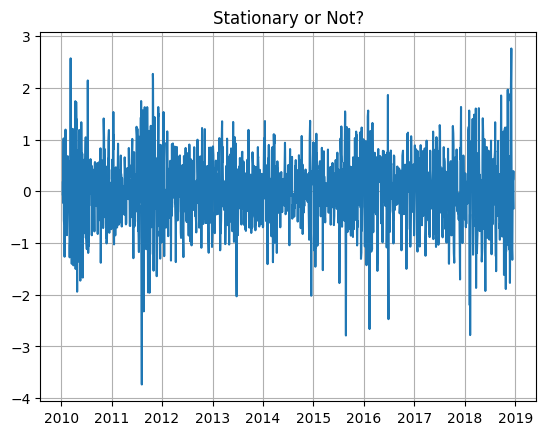

In [101]:
plt.plot(results.resid)
plt.grid()
plt.title('Stationary or Not?');

In [102]:
# Check stationarity of the residuals for each year using Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

years = train_df.index.year.unique()
for year in years:
    year_resid = results.resid[train_df.index.year == year].dropna()
    if len(year_resid) > 0:
        adf_result = adfuller(year_resid)
        print(f'Year: {year}')
        print('  ADF Statistic:', adf_result[0])
        print('  p-value:', adf_result[1])
        if adf_result[1] < 0.05:
            print('  The series is likely stationary (reject H0)')
        else:
            print('  The series is likely non-stationary (fail to reject H0)')
        print('-'*40)

Year: 2018
  ADF Statistic: -7.77059729529834
  p-value: 8.94273697325183e-12
  The series is likely stationary (reject H0)
----------------------------------------
Year: 2017
  ADF Statistic: -8.207484079683523
  p-value: 6.96129457800837e-13
  The series is likely stationary (reject H0)
----------------------------------------
Year: 2016
  ADF Statistic: -9.782842983448127
  p-value: 6.662298057170454e-17
  The series is likely stationary (reject H0)
----------------------------------------
Year: 2015
  ADF Statistic: -11.27396240077897
  p-value: 1.5126272424305774e-20
  The series is likely stationary (reject H0)
----------------------------------------
Year: 2014
  ADF Statistic: -7.188746584769742
  p-value: 2.53611889694467e-10
  The series is likely stationary (reject H0)
----------------------------------------
Year: 2013
  ADF Statistic: -6.306355808041556
  p-value: 3.31616160592072e-08
  The series is likely stationary (reject H0)
----------------------------------------
Ye

In [103]:
# Forecast the entire test data range using STL decomposition and ARIMA with specified order
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

# STL requires 'seasonal' to be an odd positive integer >= 3
# Specify ARIMA order for better modeling
print('Train data tail:')
print(train_df['Close'].tail())
stl_forecast = STLForecast(
	train_df['Close'],
	model=ARIMA,
	model_kwargs={"order": (1, 1, 1)},
	period=period,
	seasonal=13
)
stl_forecast_result = stl_forecast.fit()
# forecast for the length of the test set
forecast_steps = len(test_df)
forecast = stl_forecast_result.forecast(steps=forecast_steps)
print('Forecast head:')
print(forecast.head())
print('Forecast tail:')
print(forecast.tail())


Train data tail:
2010-01-11    27.2735
2010-01-08    26.9730
2010-01-07    27.4238
2010-01-06    27.3486
2010-01-05    26.5222
Name: Close, dtype: float64
Forecast head:
2263    26.668212
2264    27.765994
2265    28.050128
2266    28.184657
2267    28.049662
dtype: float64
Forecast tail:
3886    28.181675
3887    28.047891
3888    27.508172
3889    27.441234
3890    27.088421
dtype: float64
Forecast head:
2263    26.668212
2264    27.765994
2265    28.050128
2266    28.184657
2267    28.049662
dtype: float64
Forecast tail:
3886    28.181675
3887    28.047891
3888    27.508172
3889    27.441234
3890    27.088421
dtype: float64


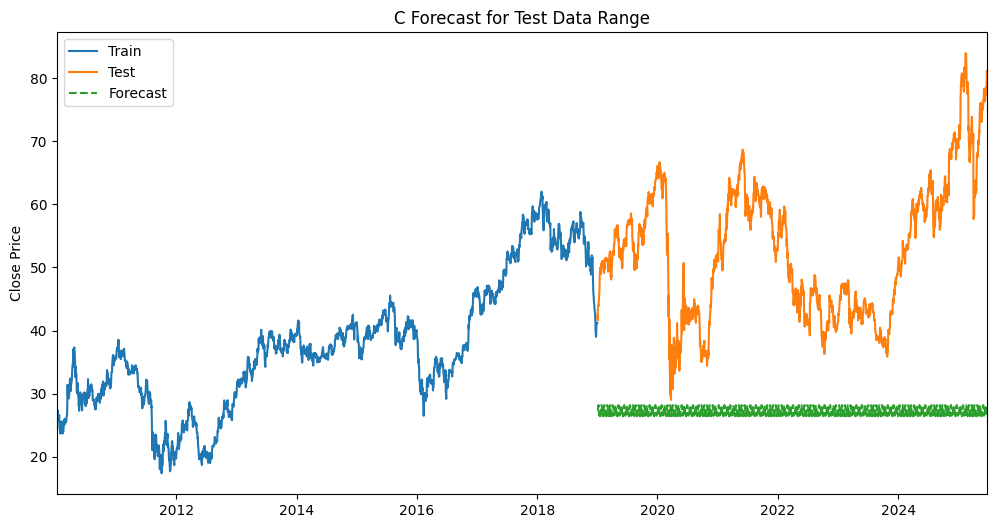

In [104]:
# plot the train, test, and forecast dataframes with x-axis limited to the dataframe date range
plt.figure(figsize=(12, 6))
plt.plot(train_df['Close'], label='Train')
plt.plot(test_df['Close'], label='Test')
forecast.index = test_df.index  # align forecast index with test data
plt.plot(forecast, label='Forecast', linestyle='--')
plt.title(f"{s_ticker} Forecast for Test Data Range")
plt.ylabel("Close Price")
plt.legend()
plt.xlim(df.index.min(), df.index.max())
plt.show()

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# STL and time series libraries
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def enhanced_stl_analysis(df, s_ticker, period=12):
    """
    Enhanced STL analysis with automatic parameter optimization and evaluation
    """
    
    # Ensure datetime index
    df.index = pd.to_datetime(df.index)
    
    # Set up train/test split
    start = str(df.index.min().date())
    end = str(df.index.max().date())
    train_end = '2018-12-31'
    test_start = '2019-01-01'
    
    train_df = df[(df.index <= train_end)]
    test_df = df[(df.index >= test_start)]
    
    print(f"Train period: {train_df.index.min()} to {train_df.index.max()}")
    print(f"Test period: {test_df.index.min()} to {test_df.index.max()}")
    print(f"Train samples: {len(train_df)}, Test samples: {len(test_df)}")
    
    if len(train_df) < 2 * period or len(test_df) == 0:
        print("❌ Insufficient data for STL analysis")
        return None
    
    # 1. STL Decomposition Analysis
    print("\n🔍 STL Decomposition Analysis")
    print("=" * 50)
    
    stl = STL(train_df['Close'], period=period, seasonal=13)
    stl_result = stl.fit()
    
    # Plot STL components
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    
    # Original
    axes[0].plot(train_df.index, train_df['Close'], 'b-', linewidth=1)
    axes[0].set_title(f'{s_ticker} - Original Close Price')
    axes[0].grid(True, alpha=0.3)
    
    # Trend
    axes[1].plot(train_df.index, stl_result.trend, 'g-', linewidth=2)
    axes[1].set_title('Trend Component')
    axes[1].grid(True, alpha=0.3)
    
    # Seasonal
    axes[2].plot(train_df.index, stl_result.seasonal, 'r-', linewidth=1)
    axes[2].set_title('Seasonal Component')
    axes[2].grid(True, alpha=0.3)
    
    # Residual
    axes[3].plot(train_df.index, stl_result.resid, 'purple', linewidth=1)
    axes[3].set_title('Residual Component')
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Component Analysis
    trend_strength = max(0, 1 - np.var(stl_result.resid) / np.var(stl_result.trend + stl_result.resid))
    seasonal_strength = max(0, 1 - np.var(stl_result.resid) / np.var(stl_result.seasonal + stl_result.resid))
    
    print(f"📊 Component Strength:")
    print(f"Trend Strength: {trend_strength:.3f}")
    print(f"Seasonal Strength: {seasonal_strength:.3f}")
    
    # 3. Automatic ARIMA Order Selection
    print("\n🎯 ARIMA Model Selection")
    print("=" * 50)
    
    def find_best_arima_order(series, max_p=3, max_q=3, max_d=2):
        """Find best ARIMA order using AIC"""
        best_aic = np.inf
        best_order = None
        best_model = None
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(series, order=(p, d, q))
                        fitted_model = model.fit()
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_order = (p, d, q)
                            best_model = fitted_model
                    except:
                        continue
        
        return best_order, best_aic, best_model
    
    # Find best ARIMA order
    best_order, best_aic, _ = find_best_arima_order(train_df['Close'])
    print(f"Best ARIMA order: {best_order}")
    print(f"Best AIC: {best_aic:.2f}")
    
    # 4. STL Forecasting with optimized ARIMA
    print("\n🚀 STL Forecasting")
    print("=" * 50)
    
    stl_forecast = STLForecast(
        train_df['Close'],
        model=ARIMA,
        model_kwargs={"order": best_order},
        period=period,
        seasonal=13
    )
    
    stl_forecast_result = stl_forecast.fit()
    
    # Generate forecasts with confidence intervals
    forecast_steps = len(test_df)
    forecast = stl_forecast_result.forecast(steps=forecast_steps)
    
    # Get confidence intervals using summary_frame method
    try:
        forecast_summary = stl_forecast_result.get_prediction(start=len(train_df), 
                                                            end=len(train_df) + forecast_steps - 1)
        forecast_ci = forecast_summary.conf_int()
    except AttributeError:
        # Alternative approach: use bootstrap or simple std estimation
        forecast_residuals = stl_forecast_result.resid
        forecast_std = np.std(forecast_residuals) if len(forecast_residuals) > 0 else np.std(train_df['Close']) * 0.1
        
        # Create confidence intervals manually (95% CI)
        z_score = 1.96  # for 95% CI
        lower_ci = forecast - z_score * forecast_std
        upper_ci = forecast + z_score * forecast_std
        
        forecast_ci = pd.DataFrame({
            'lower Close': lower_ci,
            'upper Close': upper_ci
        }, index=forecast.index if hasattr(forecast, 'index') else range(len(forecast)))
    
    # 5. Forecast Evaluation
    print("\n📈 Forecast Evaluation")
    print("=" * 50)
    
    # Align forecast with test data
    if not hasattr(forecast, 'index'):
        forecast = pd.Series(forecast, index=test_df.index)
    else:
        forecast.index = test_df.index
    
    if not hasattr(forecast_ci, 'index'):
        forecast_ci.index = test_df.index
    else:
        forecast_ci.index = test_df.index
    
    # Calculate metrics
    mse = mean_squared_error(test_df['Close'], forecast)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_df['Close'], forecast)
    mape = np.mean(np.abs((test_df['Close'] - forecast) / test_df['Close'])) * 100
    r2 = r2_score(test_df['Close'], forecast)
    
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R²: {r2:.3f}")
    
    # Direction accuracy
    actual_direction = np.sign(test_df['Close'].diff().dropna())
    forecast_series = forecast if isinstance(forecast, pd.Series) else pd.Series(forecast, index=test_df.index)
    forecast_direction = np.sign(forecast_series.diff().dropna())
    direction_accuracy = np.mean(actual_direction.values == forecast_direction.values) * 100
    print(f"Direction Accuracy: {direction_accuracy:.1f}%")
    
    # 6. Visualization
    print("\n📊 Forecast Visualization")
    print("=" * 50)
    
    # Get confidence interval column names
    ci_lower_col = forecast_ci.columns[0]
    ci_upper_col = forecast_ci.columns[1]
    
    # Static matplotlib version (primary)
    plt.figure(figsize=(15, 8))
    
    # Plot training data
    plt.plot(train_df.index, train_df['Close'], 'b-', label='Training Data', linewidth=1)
    
    # Plot actual test data
    plt.plot(test_df.index, test_df['Close'], 'k-', label='Actual', linewidth=2)
    
    # Plot forecast
    forecast_values = forecast.values if hasattr(forecast, 'values') else forecast
    plt.plot(forecast.index, forecast_values, 'r--', label='STL Forecast', linewidth=2)
    
    # Plot confidence interval
    plt.fill_between(forecast_ci.index, 
                     forecast_ci[ci_lower_col], 
                     forecast_ci[ci_upper_col], 
                     alpha=0.2, color='red', label='95% CI')
    
    plt.title(f'{s_ticker} STL Forecast vs Actual (R² = {r2:.3f}, MAPE = {mape:.1f}%)')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Optional Interactive plot with Plotly (with error handling)
    try:
        fig = go.Figure()
        
        # Training data
        fig.add_trace(go.Scatter(
            x=train_df.index,
            y=train_df['Close'],
            mode='lines',
            name='Training Data',
            line=dict(color='blue', width=1)
        ))
        
        # Actual test data
        fig.add_trace(go.Scatter(
            x=test_df.index,
            y=test_df['Close'],
            mode='lines',
            name='Actual',
            line=dict(color='black', width=2)
        ))
        
        # Forecast
        fig.add_trace(go.Scatter(
            x=forecast.index,
            y=forecast.values if hasattr(forecast, 'values') else forecast,
            mode='lines',
            name='STL Forecast',
            line=dict(color='red', width=2, dash='dash')
        ))
        
        # Confidence interval
        fig.add_trace(go.Scatter(
            x=forecast_ci.index,
            y=forecast_ci[ci_lower_col],
            fill=None,
            mode='lines',
            line_color='rgba(0,100,80,0)',
            showlegend=False
        ))
        
        fig.add_trace(go.Scatter(
            x=forecast_ci.index,
            y=forecast_ci[ci_upper_col],
            fill='tonexty',
            mode='lines',
            line_color='rgba(0,100,80,0)',
            name='95% Confidence Interval',
            fillcolor='rgba(255,0,0,0.2)'
        ))
        
        fig.update_layout(
            title=f'{s_ticker} STL Forecast vs Actual (Interactive)',
            xaxis_title='Date',
            yaxis_title='Close Price',
            hovermode='x unified',
            height=600
        )
        
        # Try to show with different renderers
        try:
            fig.show()
        except:
            print("📊 Interactive plot unavailable - using matplotlib instead")
            
    except Exception as e:
        print(f"📊 Plotly visualization skipped: {str(e)}")
        print("📊 Using matplotlib plots only")
    
    # 7. Residual Analysis
    print("\n🔍 Residual Analysis")
    print("=" * 50)
    
    residuals = test_df['Close'] - (forecast.values if hasattr(forecast, 'values') else forecast)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Residuals over time
    axes[0, 0].plot(test_df.index, residuals)
    axes[0, 0].axhline(y=0, color='r', linestyle='--')
    axes[0, 0].set_title('Residuals Over Time')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Residuals histogram
    axes[0, 1].hist(residuals, bins=20, alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('Residuals Distribution')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Q-Q plot
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Actual vs Predicted
    forecast_for_scatter = forecast.values if hasattr(forecast, 'values') else forecast
    axes[1, 1].scatter(forecast_for_scatter, test_df['Close'], alpha=0.6)
    axes[1, 1].plot([forecast_for_scatter.min(), forecast_for_scatter.max()], 
                    [forecast_for_scatter.min(), forecast_for_scatter.max()], 'r--')
    axes[1, 1].set_xlabel('Predicted')
    axes[1, 1].set_ylabel('Actual')
    axes[1, 1].set_title('Actual vs Predicted')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 8. Return Results
    results = {
        'forecast': forecast,
        'forecast_ci': forecast_ci,
        'actual': test_df['Close'],
        'metrics': {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'r2': r2,
            'direction_accuracy': direction_accuracy
        },
        'best_arima_order': best_order,
        'trend_strength': trend_strength,
        'seasonal_strength': seasonal_strength,
        'stl_result': stl_result
    }
    
    return results

# Example usage (replace with your data and ticker)
# Assuming you have df and s_ticker defined
# results = enhanced_stl_analysis(df, s_ticker)

print("Enhanced STL Analysis Function Ready!")
print("Usage: results = enhanced_stl_analysis(df, s_ticker)")

Enhanced STL Analysis Function Ready!
Usage: results = enhanced_stl_analysis(df, s_ticker)


Train period: 2010-01-05 00:00:00 to 2018-12-31 00:00:00
Test period: 2019-01-02 00:00:00 to 2025-06-24 00:00:00
Train samples: 2263, Test samples: 1628

🔍 STL Decomposition Analysis


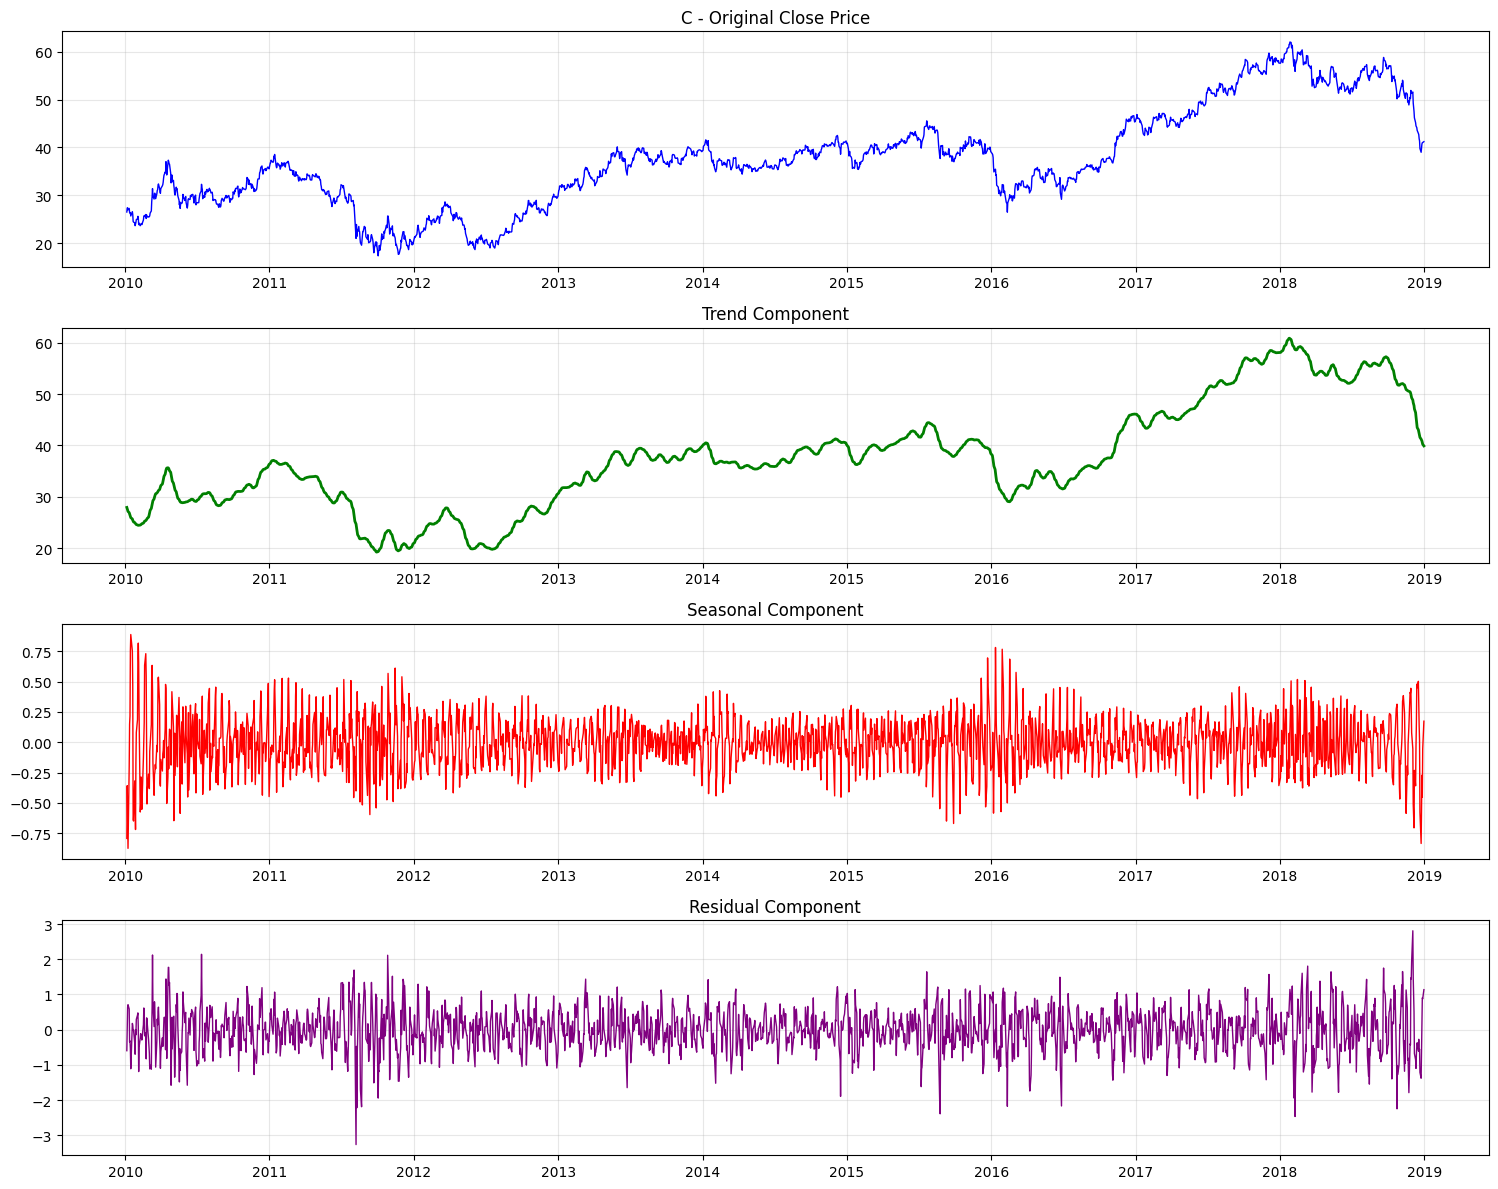

📊 Component Strength:
Trend Strength: 0.996
Seasonal Strength: 0.153

🎯 ARIMA Model Selection
Best ARIMA order: (2, 1, 3)
Best AIC: 4414.28

🚀 STL Forecasting
Best ARIMA order: (2, 1, 3)
Best AIC: 4414.28

🚀 STL Forecasting

📈 Forecast Evaluation
MSE: 766.44
RMSE: 27.68
MAE: 25.55
MAPE: 46.21%
R²: -5.761
Direction Accuracy: 49.3%

📊 Forecast Visualization

📈 Forecast Evaluation
MSE: 766.44
RMSE: 27.68
MAE: 25.55
MAPE: 46.21%
R²: -5.761
Direction Accuracy: 49.3%

📊 Forecast Visualization


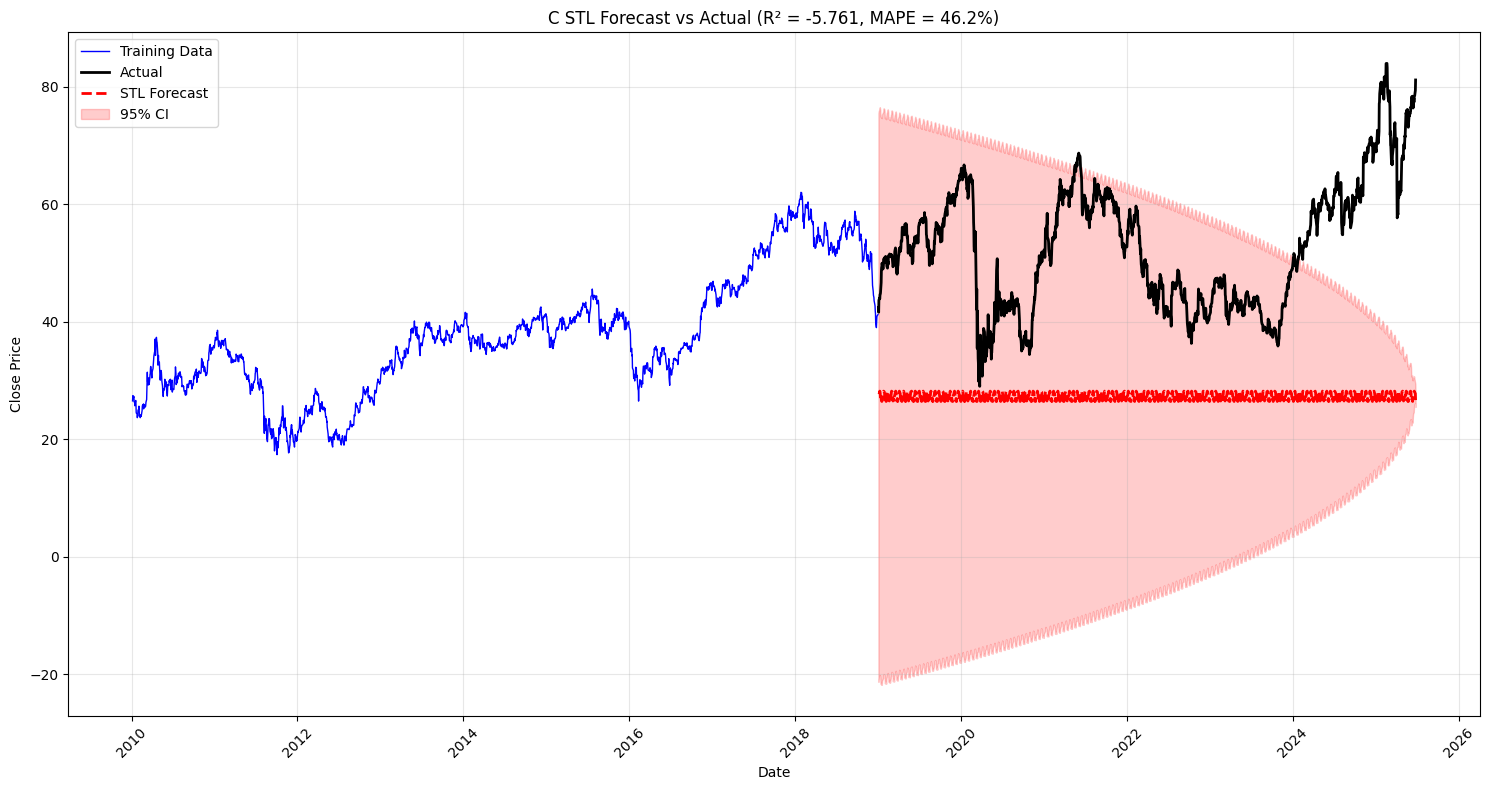

📊 Interactive plot unavailable - using matplotlib instead

🔍 Residual Analysis


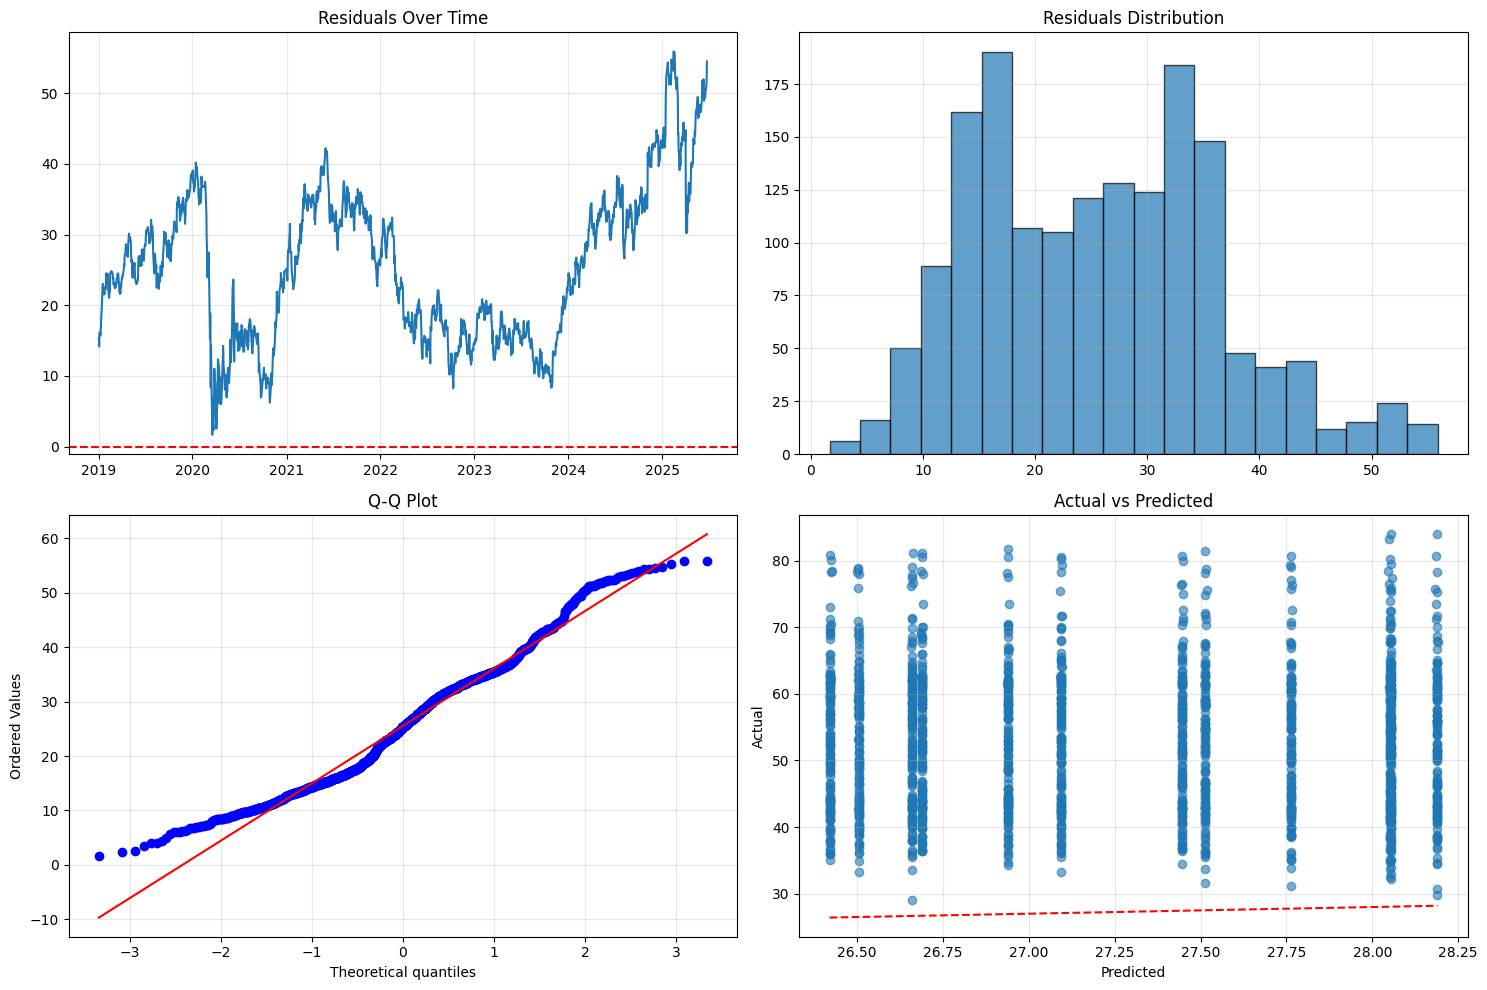

In [106]:
results = enhanced_stl_analysis(df, s_ticker)

Diagnostic Analysis:
1. Residuals Over Time (Top Left):

2019-2021: Relatively stable residuals (15-40 range)
2020: Notable dip in residuals (some negative) - likely COVID impact
2024-2025: Dramatic spike in residuals (50+) - model failing badly in recent period

2. Residuals Distribution (Top Right):

Non-normal distribution - appears bimodal/right-skewed
Two peaks around 15-20 and 30-35
This suggests heteroscedasticity (non-constant variance)

3. Q-Q Plot (Bottom Left):

Points deviate from diagonal line at extremes
Heavy tail behavior - residuals not normally distributed
Model assumptions violated

4. Actual vs Predicted (Bottom Right):

This is the most concerning plot 🚨
Predictions clustered in narrow range (~26.5-28)
Actual values span much wider range (30-80+)
Severe systematic underprediction

🚨 Key Problems Identified:
1. Model Breakdown in Recent Period:
The massive residuals in 2024-2025 suggest the STL model failed to adapt to recent market conditions.
2. Limited Prediction Range:
Your model is predicting a very narrow price range while actual prices vary dramatically.
3. Systematic Bias:
Consistent underprediction indicates the model isn't capturing the underlying trend properly.